# Context of the problem

Cintas is a company that delivers clean uniforms to customers around the city.  While GPS can help navigate routes in real-time, route planning is done in advance based on sequencing stops based on geographical considerations. In fact, after speaking with a representative, I found that they plan routes entirely on zipcodes. The zipcode of a series of stops is not always the greatest predictor of what will complete the series of stops in the least amount of time. Can we predict traffic issues before they occur so that we may avoid them?

We will explore the Real-Time Traffic Incident Reports from Austin's Open Data Portal.
(https://data.austintexas.gov/Transportation-and-Mobility/Real-Time-Traffic-Incident-Reports/dx9v-zd7x)

# Steps Taken

1. Latitude and Longitude now both float data types

2. Null values removed with little impact on number of rows

3. Traffic Report ID, Status columns removed

4. Scope of coordinates slightly reduced for a more realistic representation of the city

5. The issue_timespan column was engineered (in minutes) and the status_date column was dropped

6. Issues with negative resolution times or times beyond 24 hours were removed

7. The number of classes in the issue_reported column was reduced from 23 to 8 through either combining similar labels or dropping the class entirely due to a lack of instances.

8. Addresses & Location columns deemed less reliable/useful than coordinate data and removed

9. No relationship between high volume coordinates and issue timespan was found

10. There were correlations between coordinates and certain classes of issue reported

11. There were coorelations between issue reported and timespan

12. After visualizing incident timespan by volume, it was determined that works best for this dataset is dealing with issues that took less than 8 hours to resolve (480 minutes).

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
import plotly.express as px
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import calendar

# Data Collection/Organization

In [2]:
file = 'feature_engineering3.csv'


In [3]:
df = pd.read_csv(file, parse_dates=['published_date'])
df.head()


,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month
0,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June
1,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June
2,2020-04-17 21:25:03+00:00,Crash Service,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April
3,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April
4,2020-04-17 21:00:55+00:00,Crash Service,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April


In [4]:
df.shape

(243114, 9)

## Creating Location Categories to Identify High Volume Coordinates

I have used local landmarks to divide the city up into 12 pieces. This will help establish if there is a correlation between and issue reported and the are of town where it ocurrs.

Location definitions
vnw = The very northwest edge of the city that is west of I35 and north of 183

vcw = West of MOPAC but south of 183 and north of 290

vsw = The very southwest edge of the city that is west of I35 and south of Ben White

cnw = Central northwest of the city, west of I35, south of 183, east of MOPAC, north of MLK

cw = Central west of the city, west of I35, south of MLK, east of MOPAC, north of the river

csw = Central southwest of the city, west of I35, south of the river, east of MOPAC, north of Ben White

cne = Central northeast of the city, east of I35, South of 183, east of 183 and north of MLK

ce = Central east of the city, east of I35, south of MLK, east of 183, north of the river

cse = Central southeast of the city, east of I35, south of the river, east of 183, north of Ben White

vne = The very northeast edge of the city that is east of I35, east and north of 183

vce = The very east of the city, east 183, south of 290(east), north of Ben White/71

vse = The very southeast of the city, east of I35, south of Ben White/71

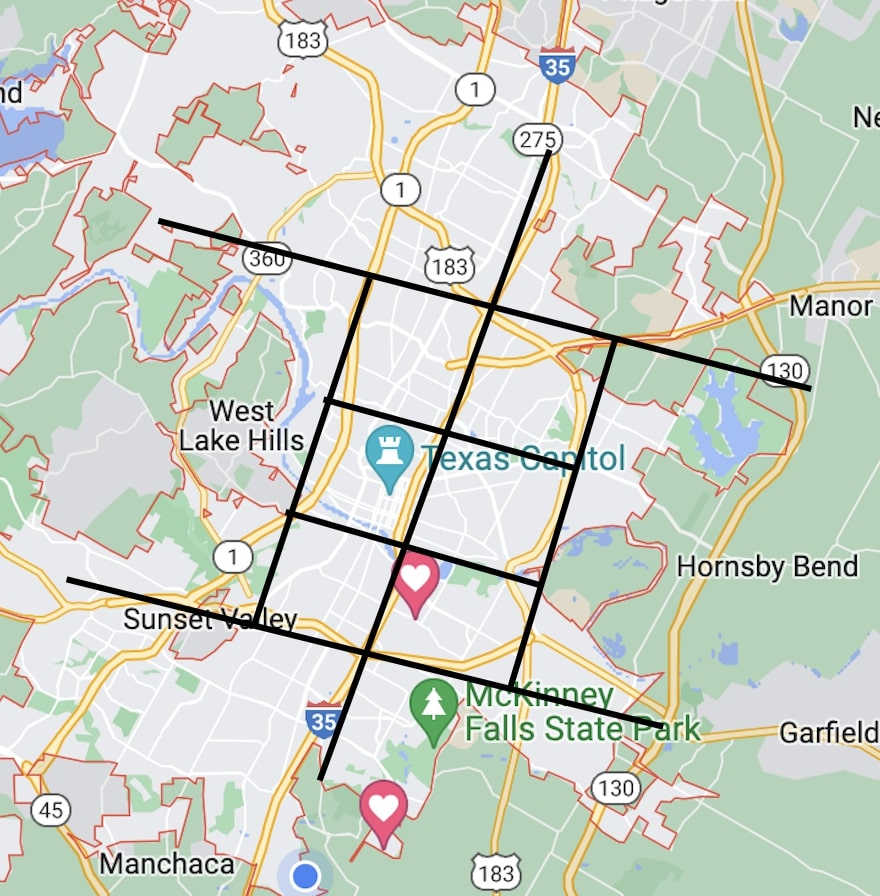

In [5]:
def partOfCity(lat, lon):
    if (lat <= 30.21638 and lon < -97.72575):
        return "vsw"
    elif (lat <= 30.21638 and lon >= -97.72575):
        return "vse"
    
    elif (lat > 30.33926 and lon < -97.72575):
        return "vnw"
    elif (lat >= 30.33926 and lon >= -97.72575):
        return "vne"
    
    elif (lat >= 30.21638 and lat < 30.33926 and lon < -97.75816):
        return "vcw"
    elif (lat >= 30.21638 and lat <= 30.33926 and lon >= -97.66523):
        return "vce"
    #inner grid
    elif (lat < 30.25108 and lat >= 30.21638 and lon < -97.72575 and lon > -97.75816):
        return "csw"
    elif (lat < 30.25108 and lat >= 30.21638 and lon >= -97.72575 and lon < -97.66523):
        return "cse"
    
    elif (lat < 30.33926 and lat > 30.27887 and lon > -97.72575 and lon < -97.66523):
        return "cne"
    elif (lat <= 30.33926 and lat > 30.27887 and lon <= -97.72575 and lon > -97.75816):
        return "cnw"
    
    elif(lat >= 30.25108 and lat <= 30.27887 and lon >= -97.72575 and lon <= -97.66523):
        return "ce"
    elif(lat > 30.25108 and lat < 30.27887 and lon < -97.72575 and lon > -97.75816):
        return "cw"
    else:
        return "other"
    #30.2672, -97.7431

# New Feature for "Latitude" and "Longitude" Called "Region"
I want to create a new column called "region" and use the above fuction to divide up incidents into one of 12 areas.

In [6]:
df['region'] = df.apply(lambda x: partOfCity(x['Latitude'], x['Longitude']), axis=1)

In [7]:
df['region'].value_counts()

vne    50322
vnw    37346
vcw    32050
vsw    31051
cne    18536
vse    14623
cw     14575
vce    13741
cnw    10385
csw     8308
cse     6856
ce      5321
Name: region, dtype: int64

### A visualization for "Region" distribution

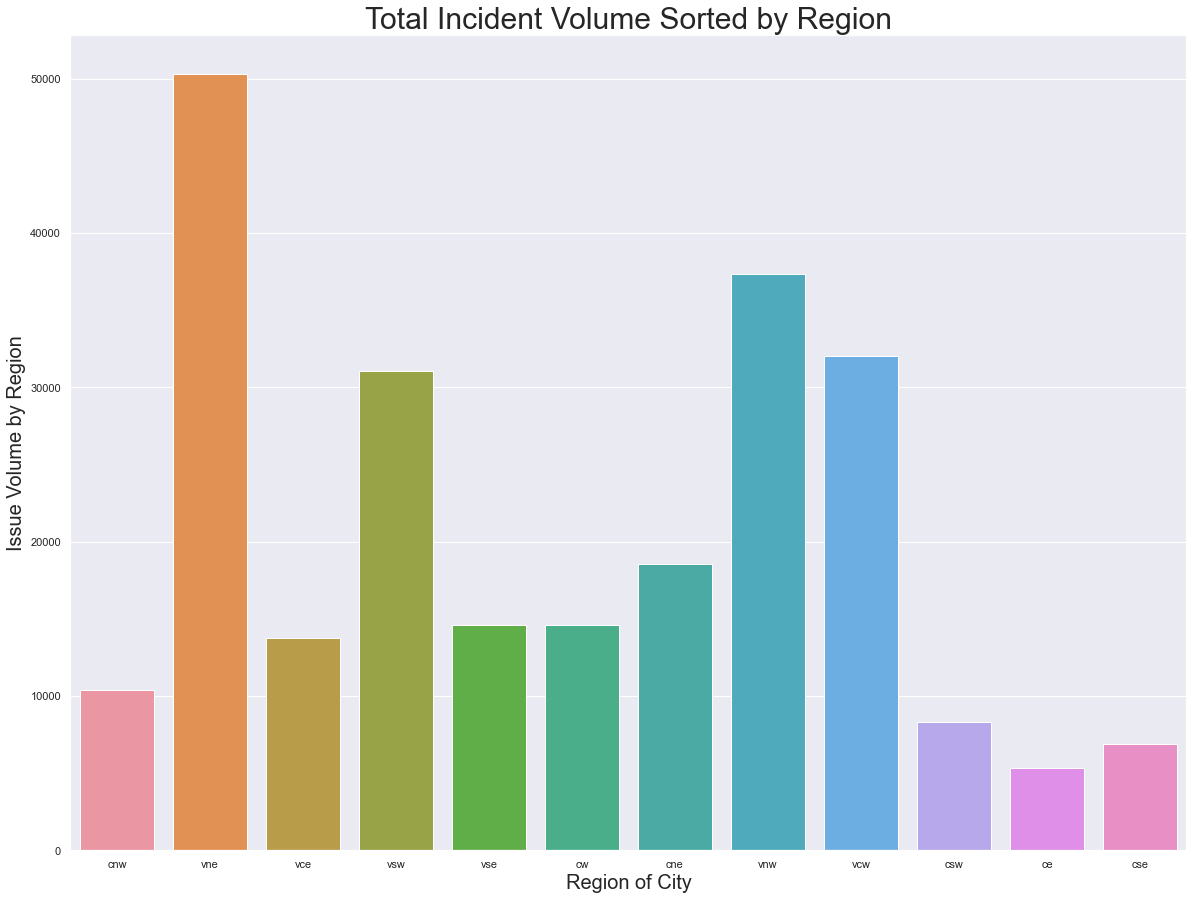

In [19]:
sns.countplot(x='region', data= df)
plt.xlabel('Region of City', fontsize=20)
plt.ylabel('Issue Volume by Region', fontsize=20)
plt.title('Total Incident Volume Sorted by Region', fontsize=30)
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

# Using a Central Coordinate to Create Quadrants
Let's use the coordinates of the absolute center of the city to divide the city into Quadrants to try and back up our grid above.
City center coordinates: 30.2672, -97.7431

In [20]:
def CheckQuadrant(x, y): 
    if x > 30.2672 and y > -97.7431:
        return 'ne'
    elif x < 30.2672 and y > -97.7431:
        return 'se'
    elif x < 30.2672 and y < -97.7431:
        return 'sw'    
    else:
        return 'nw'
        


In [21]:
df['quadrant'] = df.apply(lambda x: CheckQuadrant(x['Latitude'], x['Longitude']), axis=1)

In [22]:
df.quadrant.value_counts()

ne    97236
sw    56142
nw    49123
se    40613
Name: quadrant, dtype: int64

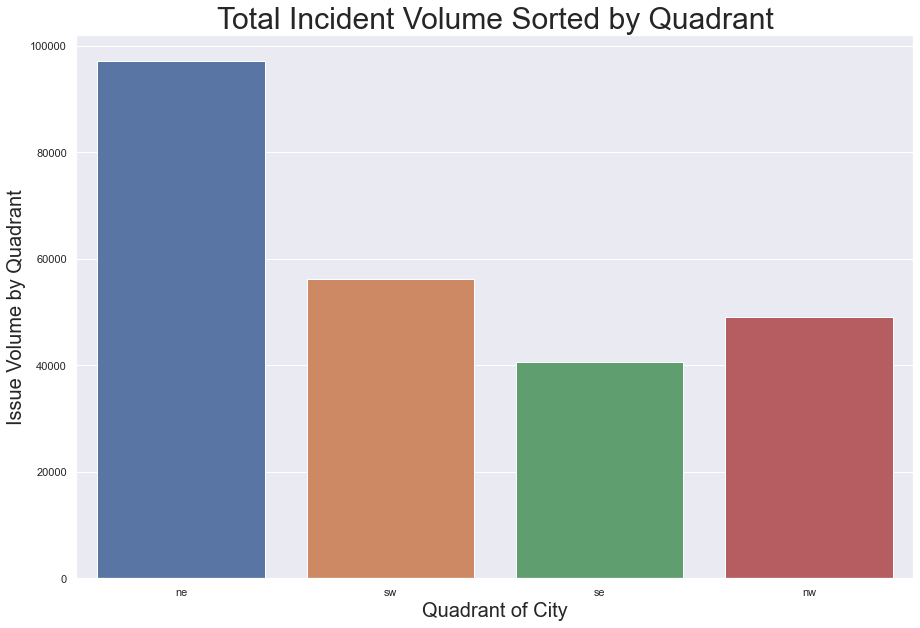

In [23]:
sns.countplot(x='quadrant', data= df)
plt.xlabel('Quadrant of City', fontsize=20)
plt.ylabel('Issue Volume by Quadrant', fontsize=20)
plt.title('Total Incident Volume Sorted by Quadrant', fontsize=30)
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

### Compare and Contrast Region and Quadrant Results

Similarities:
Both functions have most incidents ocurring in the northeast of the city. 

Differences:
A substantial decrease in the northwest incidents and a comparable rise in incidents in the south east.

In [24]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [25]:
df['dist_cntr_km'] = df.apply(lambda x: haversine_array(x['Latitude'], x['Longitude'], 30.2672, -97.7431), axis=1)

Text(0.5, 1.0, 'Volume of Issues Reported in Relation to Distance from City Center')

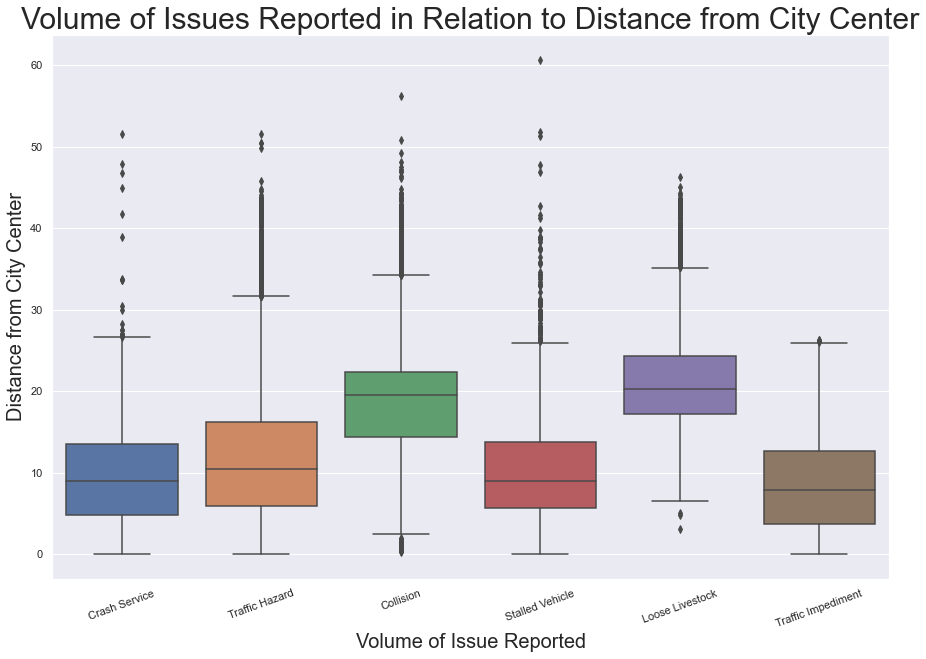

In [26]:
ax = sns.boxplot(x= 'issue_reported', y='dist_cntr_km', data=df)
plt.xlabel('Volume of Issue Reported' , fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)
plt.ylabel('Distance from City Center', fontsize=20)
sns.set(rc={'figure.figsize':(20,15)})
plt.title('Volume of Issues Reported in Relation to Distance from City Center', fontsize=30)

This plot confirms what we explored in EDA pt2 notebook when we looked at issue distribution on a map.

#### Compare and Contrast of Previeous Conclusions

Similarities/Confirmations:
Loose livestock appeared mostly in the east, far from the city center.

The stalled vehicle, crash service and traffic impediment seem to add to the evidence that they are much larger issues in the central part of the city. 

Differences/Clarifications

On the maps it had appeared that traffic hazards and collisions were evenly distributed. Now we see that this is not quite the case and that traffic hazards ocurr in more central locations and for collision the opposite is true.




In [27]:
df.shape

(243114, 12)

Text(0.5, 1.0, 'Issue Timespan in Relation to Distance from City Center')

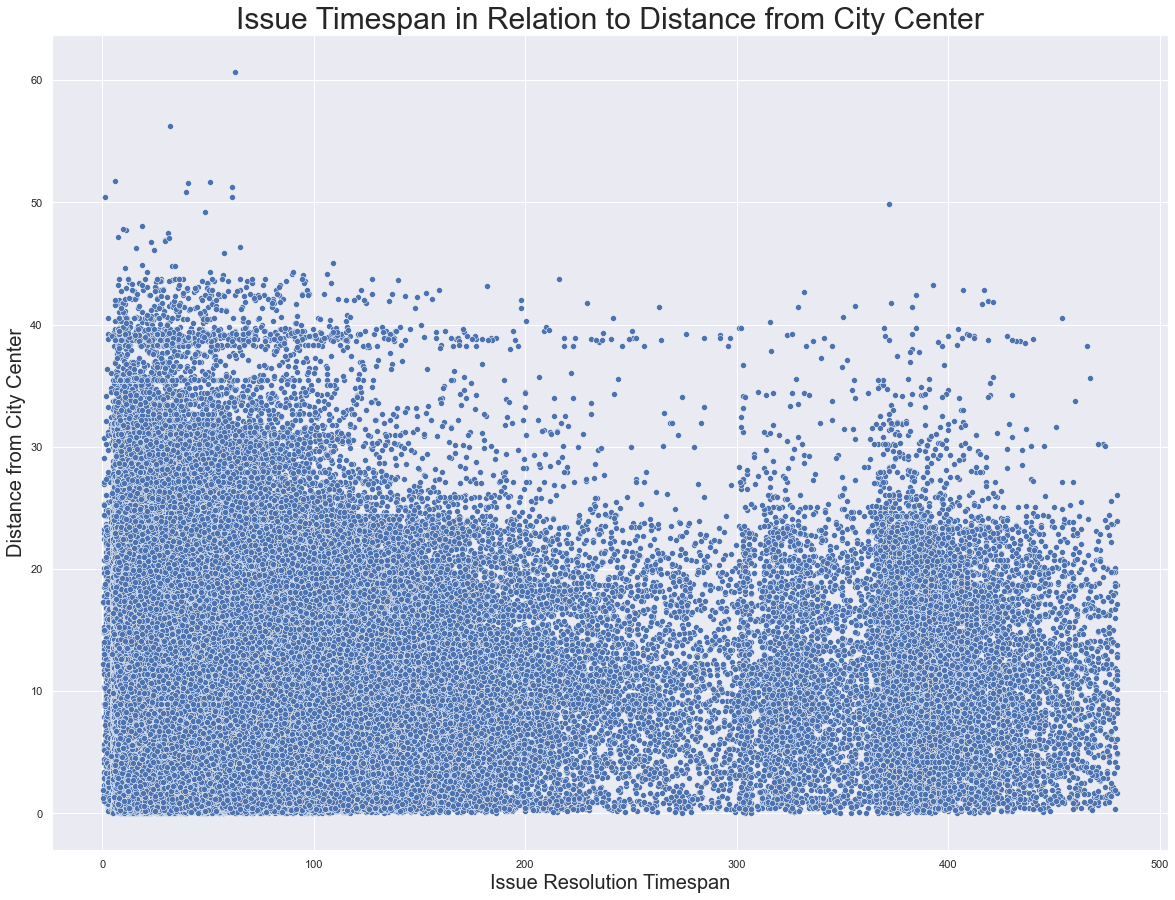

In [28]:
ax = sns.scatterplot(x= 'issue_timespan', y='dist_cntr_km', data=df)
plt.xlabel('Issue Resolution Timespan' , fontsize=20)
plt.ylabel('Distance from City Center', fontsize=20)
sns.set(rc={'figure.figsize':(20,15)})
plt.title('Issue Timespan in Relation to Distance from City Center', fontsize=30)

There doesn't appear to be much to glean from this scatter plot.

# Conclusions


### Region & Latitudinal/Longitudinal Distance from City Center

Both functions show that most incidents happen in the northeast of the city.


## Save to New .csv

In [29]:
df.to_csv('feature_engineering4.csv')